In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
# 자료 read
data_path = '생성자료/enhanced_churn_data_100k.csv'
df = pd.read_csv(data_path)

In [3]:
# 파생변수 생성 (Feature Engineering)
# "최근 3개월간 사용 실적이 없거나 낮으면 이탈"이라는 현직자 룰을 데이터에 반영
df['recent_3m_spent'] = df['spent_m1'] + df['spent_m2'] + df['spent_m3']
df['past_3m_spent'] = df['spent_m4'] + df['spent_m5'] + df['spent_m6']
df['spent_change_ratio'] = df['recent_3m_spent'] / (df['past_3m_spent'] + 1)

In [6]:
# 불필요한 컬럼 제거 (Feature Selection)
# customer_id: 단순 식별자
# contract_cancelled: 정답지(Target)가 유출되는 변수이므로 삭제 (Data Leakage 방지)
df_clean = df.drop(['customer_id', 'contract_cancelled'], axis=1)

In [7]:
# one_hot encoder
df_final = pd.get_dummies(df_clean)

### 데이터 분리

In [8]:
X = df_final.drop('churn', axis=1)  # 정답 컬럼 제외한 모든 변수
y = df_final['churn']               # 정답 컬럼

In [9]:
print(X.shape, y.shape)

(100000, 55) (100000,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2025, stratify=y
)

In [11]:
print(X_train.shape, X_test.shape)

(80000, 55) (20000, 55)


In [12]:
# 불균형 가중치 계산 (scale_pos_weight 설정값)
scale_pos_weight_value = (y_train == 0).sum() / (y_train == 1).sum()
print(scale_pos_weight_value)

38.486673247778874


In [13]:
import lightgbm as lgb

In [14]:
lgbm_params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 3,          
    'min_gain_to_split': 0.1,       
    'scale_pos_weight': scale_pos_weight_value, # 계산된 값 적용
    'random_state': 2025
}

In [15]:
lgb_model = lgb.LGBMClassifier(**lgbm_params)

In [16]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Info] Number of positive: 2026, number of negative: 77974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5401
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025325 -> initscore=-3.650312
[LightGBM] [Info] Start training from score -3.650312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,3
,min_child_samples,20


In [29]:
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

print(y_pred, y_proba)

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[1 0 0 ... 0 0 1] [7.47958914e-01 2.71960872e-05 6.78772493e-05 ... 3.83487004e-05
 1.79275074e-01 7.86188024e-01]


In [31]:
print(f"ROC-AUC 점수: {roc_auc_score(y_test, y_proba):.4f}")

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print("\nClassification Report (기본 임계값 0.5):\n", classification_report(y_test, y_pred))

ROC-AUC 점수: 0.8841
Confusion Matrix:
 [[17752  1742]
 [  232   274]]

Classification Report (기본 임계값 0.5):
               precision    recall  f1-score   support

           0       0.99      0.91      0.95     19494
           1       0.14      0.54      0.22       506

    accuracy                           0.90     20000
   macro avg       0.56      0.73      0.58     20000
weighted avg       0.97      0.90      0.93     20000



In [17]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [27]:
importance_df.head()

,Feature,Importance
3,marketing_open_rate_6m,2300
1,tenure_months,1367
2,complaints_6m,1352
0,age,1238
30,spent_change_ratio,1197


In [18]:
import seaborn as sb


[Feature Importance]
                   Feature  Importance
3   marketing_open_rate_6m        2300
1            tenure_months        1367
2            complaints_6m        1352
0                      age        1238
30      spent_change_ratio        1197
24          total_login_6m        1022
21                login_m1         864
12                login_m4         860
6                 login_m6         853
8                   txn_m5         832
15                login_m3         828
18                login_m2         768
9                 login_m5         767
11                  txn_m4         723
5                   txn_m6         696
13                spent_m3         658
14                  txn_m3         654
20                  txn_m1         647
7                 spent_m5         637
17                  txn_m2         592
4                 spent_m6         581
10                spent_m4         563
16                spent_m2         533
19                spent_m1         515
23 

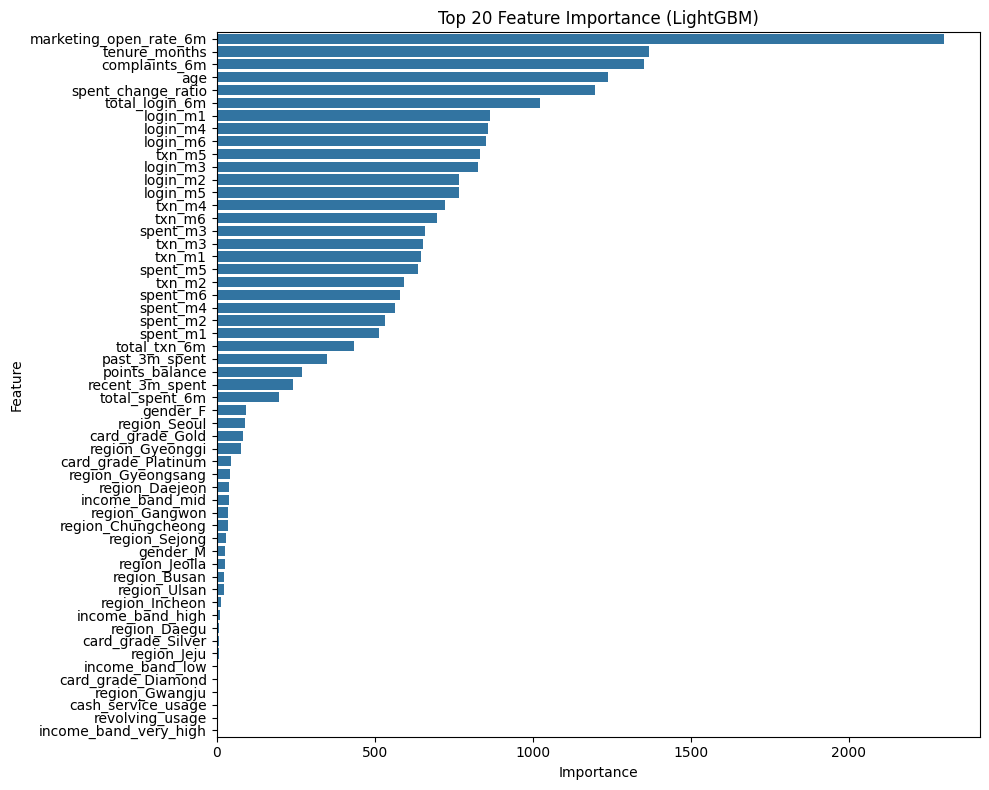

In [19]:
# 5. Top Feature 시각화 결과를 파일로 저장
plt.figure(figsize=(10, 8))
sb.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 Feature Importance (LightGBM)')
plt.tight_layout()
plt.savefig('lgbm_feature_importance.png')

print("\n[Feature Importance]")
print(importance_df)

### feature 15개 선정

In [82]:
importance_df.head(15)

,Feature,Importance
3,marketing_open_rate_6m,2300
1,tenure_months,1367
2,complaints_6m,1352
0,age,1238
30,spent_change_ratio,1197
24,total_login_6m,1022
21,login_m1,864
12,login_m4,860
6,login_m6,853
8,txn_m5,832


### 변수선정

In [43]:
HIGH_IMPORTANCE_FEATURES = ['marketing_open_rate_6m', 'tenure_months',
                           'complaints_6m', 'age', 'spent_change_ratio',
                           'login_m1', 'login_m3', 'login_m2',
                           'spent_m1','spent_m2','spent_m3', 
                           'txn_m3', 'txn_m1','txn_m2',
                           ]

In [44]:
df_filtered = df[HIGH_IMPORTANCE_FEATURES]
df_filtered.head()

,marketing_open_rate_6m,tenure_months,complaints_6m,age,spent_change_ratio,login_m1,login_m3,login_m2,spent_m1,spent_m2,spent_m3,txn_m3,txn_m1,txn_m2
0,0.610,17,2,47,0.982125,13,20,14,537047,595727,664237,11,9,11
1,0.688,71,0,40,1.186275,19,16,21,596336,624251,568691,12,15,9
2,0.674,83,1,49,0.861285,12,21,13,6433161,4963968,6364426,126,188,197
3,0.454,38,1,60,1.006479,6,13,15,1507011,1441812,2146611,41,25,22
4,0.789,108,0,39,0.978803,15,18,13,5001895,4933706,5188342,153,120,109


In [45]:
df_filtered.shape

(100000, 14)

In [46]:
df_encoded = pd.get_dummies(df_filtered, dtype=int)
X = df_encoded

In [47]:
X.shape, y.shape

((100000, 14), (100000,))

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2025, stratify=y
)

In [49]:
lgb_model = lgb.LGBMClassifier(**lgbm_params)

In [50]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Info] Number of positive: 2026, number of negative: 77974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2339
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.025325 -> initscore=-3.650312
[LightGBM] [Info] Start training from score -3.650312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,3
,min_child_samples,20


In [51]:
y_pred = lgb_model.predict(X_test)
y_proba = lgb_model.predict_proba(X_test)[:, 1]

print(y_pred, y_proba)

print(f"ROC-AUC 점수: {roc_auc_score(y_test, y_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report (기본 임계값 0.5):\n", classification_report(y_test, y_pred))

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[1 0 0 ... 0 0 1] [6.17353587e-01 8.22995294e-05 1.14999895e-05 ... 3.77297227e-05
 1.73039988e-01 6.49423133e-01]
ROC-AUC 점수: 0.8849
Confusion Matrix:
 [[17380  2114]
 [  207   299]]

Classification Report (기본 임계값 0.5):
               precision    recall  f1-score   support

           0       0.99      0.89      0.94     19494
           1       0.12      0.59      0.20       506

    accuracy                           0.88     20000
   macro avg       0.56      0.74      0.57     20000
weighted avg       0.97      0.88      0.92     20000



In [64]:
print(y_pred.shape)
print(y_proba.shape)

(20000,)
(20000,)


In [69]:
X_all = df_encoded
X_all = X_all.reindex(columns=X.columns, fill_value=0)
df_encoded['churn_proba'] = lgb_model.predict_proba(X_all)[:, 1]

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1


In [70]:
# 확률을 이용한 위험 티어 분류 (Ranking Strategy)
# 비즈니스 전략: 전체 고객 중 상위 1%, 5%, 10%를 집중 관리 대상으로 분류
threshold_99 = df_encoded['churn_proba'].quantile(0.99)
threshold_95 = df_encoded['churn_proba'].quantile(0.95)
threshold_90 = df_encoded['churn_proba'].quantile(0.90)

In [75]:
def assign_risk_tier(proba):
    if proba >= threshold_99:
        return 1
    elif proba >= threshold_95:
        return 2
    elif proba >= threshold_90:
        return 3
    else:
        return 4

df_encoded['risk_tier'] = df_encoded['churn_proba'].apply(assign_risk_tier)

In [76]:
df_encoded.head()

,marketing_open_rate_6m,tenure_months,complaints_6m,age,spent_change_ratio,login_m1,login_m3,login_m2,spent_m1,spent_m2,spent_m3,txn_m3,txn_m1,txn_m2,churn_proba,risk_tier
0,0.610,17,2,47,0.982125,13,20,14,537047,595727,664237,11,9,11,9.811141e-05,4
1,0.688,71,0,40,1.186275,19,16,21,596336,624251,568691,12,15,9,2.758047e-05,4
2,0.674,83,1,49,0.861285,12,21,13,6433161,4963968,6364426,126,188,197,4.515115e-08,4
3,0.454,38,1,60,1.006479,6,13,15,1507011,1441812,2146611,41,25,22,1.913283e-01,4
4,0.789,108,0,39,0.978803,15,18,13,5001895,4933706,5188342,153,120,109,1.766503e-05,4


In [77]:
df_encoded.shape

(100000, 16)

### 모델 저장

In [78]:
import joblib
import os
import pandas as pd
# lgbm_model 또는 gbc_model 등 최종 학습된 모델이라고 가정합니다.

# 1. 모델 저장
os.makedirs('models', exist_ok=True)
joblib.dump(lgb_model, 'models/final_churn_model.pkl')
print("모델이 'final_churn_model.pkl'로 저장되었습니다.")

# 2. 모델 로드 (나중에 예측할 때)
loaded_model = joblib.load('models/final_churn_model.pkl')
print("모델 로드 완료.")

모델이 'final_churn_model.pkl'로 저장되었습니다.
모델 로드 완료.


In [79]:
churn_proba_all = lgb_model.predict_proba(X_all)[:, 1]

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1


In [80]:
risk_thresholds = {
    'T99': np.quantile(churn_proba_all, 0.99),
    'T95': np.quantile(churn_proba_all, 0.95),
    'T90': np.quantile(churn_proba_all, 0.90)
}

joblib.dump(risk_thresholds, 'models/risk_thresholds.pkl')

['models/risk_thresholds.pkl']